In [0]:
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
 BFS.cpp			     'poseLSTM2 (2).index'
 BI2				     'poseLSTM2 (2).meta'
 checkpoint			      poseLSTM2.data-00000-of-00001
'checkpoint (1)'		      poseLSTM2.index
'checkpoint (2)'		      poseLSTM2.meta
'Colab Notebooks'		      poseLSTM2.pb
 data3				      poseLSTM.data-00000-of-00001
 eyes				      poseLSTM_model
'poseLSTM2 (1).data-00000-of-00001'   RNN-HAR-2D-Pose-database.zip
'poseLSTM2 (1).index'		      train_supervised_pose.csv
'poseLSTM2 (1).meta'		     

In [0]:
!unzip "/content/drive/My Drive/RNN-HAR-2D-Pose-database.zip"

Archive:  /content/drive/My Drive/RNN-HAR-2D-Pose-database.zip
   creating: RNN-HAR-2D-Pose-database/
  inflating: RNN-HAR-2D-Pose-database/README.md  
  inflating: RNN-HAR-2D-Pose-database/X_val2.txt  
  inflating: RNN-HAR-2D-Pose-database/X_val.txt  
  inflating: RNN-HAR-2D-Pose-database/Y_train.txt  
  inflating: RNN-HAR-2D-Pose-database/Y_test.txt  
  inflating: RNN-HAR-2D-Pose-database/X_train.txt  
  inflating: RNN-HAR-2D-Pose-database/X_test.txt  


In [0]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os

## Preparing dataset:

In [0]:
# Useful Constants

# Output classes to learn how to classify
LABELS = [    
    "JUMPING",
    "JUMPING_JACKS",
    "BOXING",
    "WAVING_2HANDS",
    "WAVING_1HAND",
    "CLAPPING_HANDS"

] 
DATASET_PATH = "RNN-HAR-2D-Pose-database/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

n_steps = 32 # 32 timesteps per series

In [0]:

# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)


## Set Parameters:


In [0]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

n_hidden = 34 # Hidden layer num of features
n_classes = 6 

#updated for learning-rate decay
# calculated as: decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0025 #used if decaying_learning_rate set to False
init_learning_rate = 0.005
decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

training_iters = training_data_count *300  # Loop 300 times on the dataset, ie 300 epochs
batch_size = 512
display_iter = batch_size*8  # To show test set accuracy during training

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")




Instructions for updating:
Colocations handled automatically by placer.
(X shape, y shape, every X's mean, every X's standard deviation)
((22625, 32, 36), (5751, 1), 251.01117, 126.12204)

The dataset has not been preprocessed, is not normalised etc


## Utility functions for training:

In [0]:
def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.add(tf.matmul(lstm_last_output, _weights['out']), _biases['out'], name='output')


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



## Build the network:

In [0]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input], name='input')
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1), name='prediction')
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')




For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Train the network:

In [0]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = range(0,len(X_train))

while step * batch_size <= training_iters:
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = range(0,len(X_train)) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #512:  Learning rate = 0.005000:   Batch Loss = 4.242367, Accuracy = 0.13671875
PERFORMANCE ON TEST SET:             Batch Loss = 3.44947385788, Accuracy = 0.160319939256
Iter #4096:  Learning rate = 0.005000:   Batch Loss = 2.985750, Accuracy = 0.287109375
PERFORMANCE ON TEST SET:             Batch Loss = 3.07006788254, Accuracy = 0.25699877739
Iter #8192:  Learning rate = 0.005000:   Batch Loss = 2.888960, Accuracy = 0.326171875
PERFORMANCE ON TEST SET:             Batch Loss = 2.88224387169, Accuracy = 0.371065914631
Iter #12288:  Learning rate = 0.005000:   Batch Loss = 2.830805, Accuracy = 0.306640625
PERFORMANCE ON TEST SET:             Batch Loss = 2.84467601776, Accuracy = 0.290558159351
Iter #16384:  Learning rate = 0.005000:   Batch Loss = 2.647563, Accuracy = 0.447265625
PERFORMANCE ON TEST SET:             Batch Loss = 2.6444606781, Accuracy = 0.432098776102
Iter #20480:  Learning rate = 0.005000:   Batch Loss = 2.513466, Accuracy = 0.462890625
PERFORMANCE ON TEST SET:

## Results:



1659
13256


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


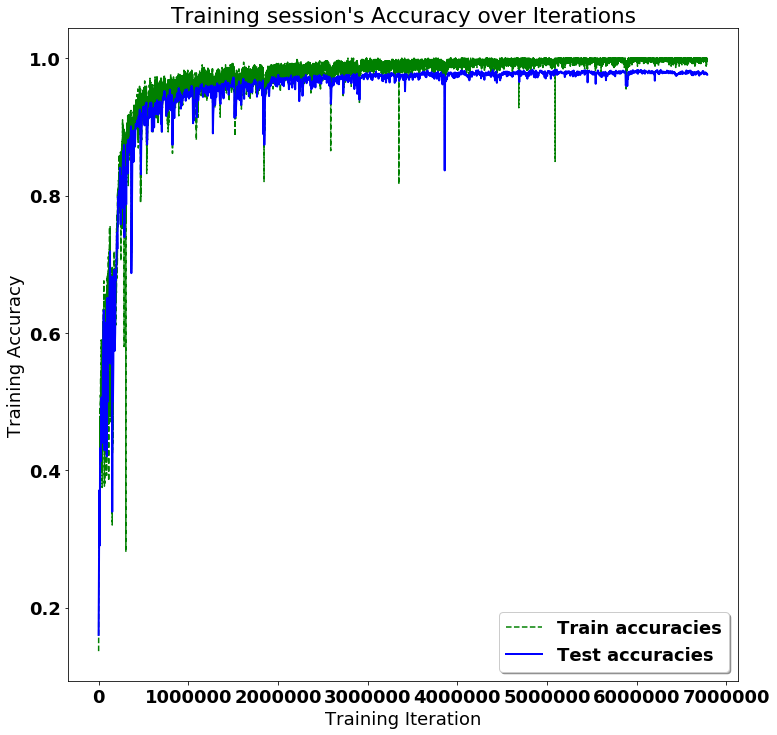

Testing Accuracy: 97.565639019%

Precision: 97.5692825893%
Recall: 97.5656407581%
f1_score: 97.5431525698%

Confusion Matrix:
Created using test set of 5751 datapoints, normalised to % of each class in the test dataset


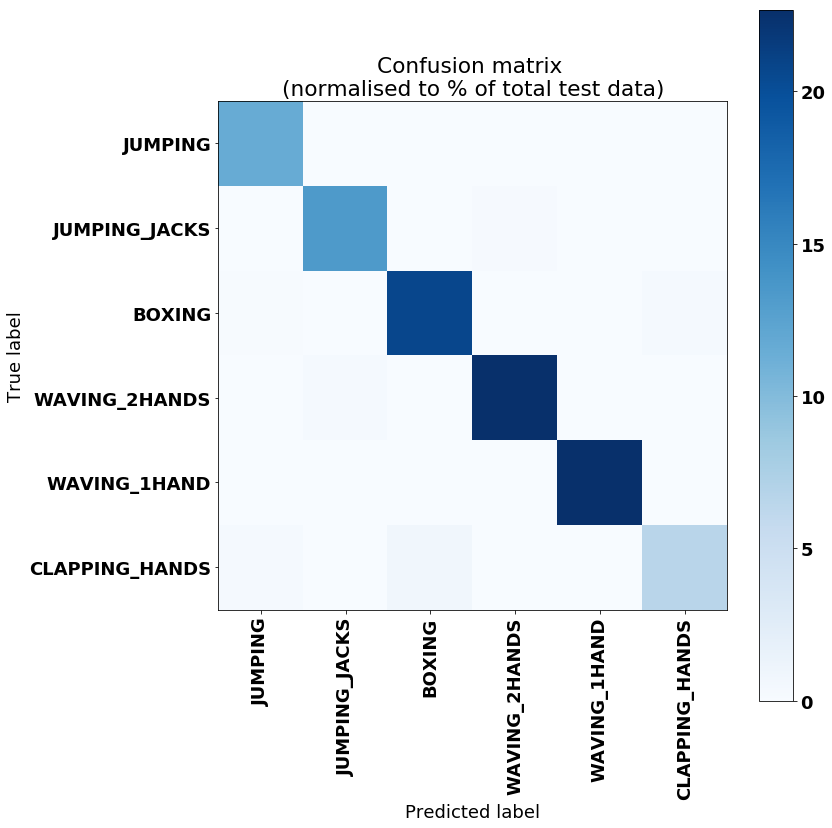

In [0]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print len(test_accuracies)
print len(train_accuracies)

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [0]:

X_val_path = DATASET_PATH + "X_val.txt"
X_val = load_X(X_val_path)
print X_val

preds = sess.run(
   [pred],
   feed_dict={
       x: X_val
  }
)
print "ok\n"
print preds

[[[307.589 162.976 319.364 ...   0.    329.752 161.651]
  [307.567 162.979 319.362 ...   0.    328.527 161.655]
  [306.298 162.951 319.351 ...   0.    328.495 161.681]
  ...
  [293.291 122.534 307.676 ... 128.953 315.438 119.884]
  [289.392 140.743 307.615 ...   0.    315.393 139.408]
  [295.848 161.658 307.628 ... 160.331 314.112 160.264]]]
ok

[array([[ 5.167862  , -1.5922406 , -0.6538908 , -0.7053172 , -1.3355899 ,
        -0.80608106]], dtype=float32)]


In [0]:
#sess.close()
print test_accuracies

[0.16031994, 0.25699878, 0.3710659, 0.29055816, 0.43209878, 0.4277517, 0.4133194, 0.4823509, 0.50599897, 0.44757435, 0.44009736, 0.5033907, 0.5645975, 0.62076163, 0.6329334, 0.61919665, 0.42931664, 0.50130415, 0.543036, 0.61484957, 0.5894627, 0.5812902, 0.42027473, 0.6016345, 0.6510172, 0.49991307, 0.6362372, 0.5941575, 0.621631, 0.6531038, 0.6692749, 0.7188315, 0.55538166, 0.5936359, 0.62041384, 0.64649624, 0.68196833, 0.3395931, 0.5680751, 0.50026083, 0.5531212, 0.654321, 0.69170576, 0.6225004, 0.5739871, 0.6005912, 0.6797079, 0.6769258, 0.69240135, 0.71848375, 0.7454356, 0.7221353, 0.76073724, 0.7979482, 0.78403753, 0.80629456, 0.7880369, 0.80403405, 0.8403756, 0.8078595, 0.75795513, 0.8009042, 0.8170753, 0.82837766, 0.7817771, 0.8379412, 0.8473309, 0.86506695, 0.827856, 0.8735872, 0.73934966, 0.8066423, 0.82837766, 0.84089726, 0.8379412, 0.78699356, 0.8328986, 0.8742827, 0.8716745, 0.8621109, 0.83237696, 0.8814119, 0.86228484, 0.8668058, 0.87323946, 0.8692401, 0.88436794, 0.8808902

In [0]:
saver = tf.train.Saver()
# !mkdir model
save_path = saver.save(sess, 'model3/')

In [0]:
def freeze_graph(model_dir, output_node_names):
    """Extract the sub graph defined by the output nodes and convert 
    all its variables into constant 
    Args:
        model_dir: the root folder containing the checkpoint state file
        output_node_names: a string, containing all the output node's names, 
                            comma separated
    """
    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            "directory: %s" % model_dir)

    if not output_node_names:
        print("You need to supply the name of a node to --output_node_names.")
        return -1

    # We retrieve our checkpoint fullpath
    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path
    
    # We precise the file fullname of our freezed graph
    absolute_model_dir = "/".join(input_checkpoint.split('/')[:-1])
#     absolute_model_dir = 'model/'
    output_graph = absolute_model_dir + "/frozen_model.pb"

    # We clear devices to allow TensorFlow to control on which device it will load operations
    clear_devices = True

    # We start a session using a temporary fresh Graph
    with tf.Session(graph=tf.Graph()) as sess:
        # We import the meta graph in the current default Graph
        saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

        # We restore the weights
        saver.restore(sess, input_checkpoint)

        # We use a built-in TF helper to export variables to constants
        output_graph_def = tf.compat.v1.graph_util.convert_variables_to_constants(
            sess, # The session is used to retrieve the weights
            tf.get_default_graph().as_graph_def(), # The graph_def is used to retrieve the nodes 
            output_node_names.split(",") # The output node names are used to select the usefull nodes
        ) 

        # Finally we serialize and dump the output graph to the filesystem
        with tf.gfile.GFile(output_graph, "wb") as f:
            f.write(output_graph_def.SerializeToString())
        print("%d ops in the final graph." % len(output_graph_def.node))

    return
  
freeze_graph('model2', 'output')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model2/model
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.
1149 ops in the final graph.


In [0]:
# !pip install pydrive

In [0]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# uploaded = drive.CreateFile({'title': 'poseLSTM2.data-00000-of-00001'})
# uploaded.SetContentFile('model/poseLSTM2.data-00000-of-00001')
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

# uploaded = drive.CreateFile({'title': 'poseLSTM2.index'})
# uploaded.SetContentFile('model/poseLSTM2.index')
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

# uploaded = drive.CreateFile({'title': 'poseLSTM2.meta'})
# uploaded.SetContentFile('model/poseLSTM2.meta')
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

# uploaded = drive.CreateFile({'title': 'checkpoint'})
# uploaded.SetContentFile('model/checkpoint')
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))


In [0]:
# tf.saved_model.simple_save(sess,
#                           export_dir='newpb3',
#                           inputs={'Input': x},
#                           outputs={'output': y})

# #saved
# uploaded = drive.CreateFile({'title': 'poseLSTM2.pb'})
# uploaded.SetContentFile('newpb3/saved_model.pb')
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))


In [0]:
# import tensorflow.python.saved_model
# from tensorflow.python.saved_model import tag_constants
# from tensorflow.python.saved_model.signature_def_utils_impl import predict_signature_def

# builder = tf.saved_model.builder.SavedModelBuilder('./SavedModel/')
# signature = predict_signature_def(inputs={'input': x},
#                                   outputs={'output': y})

# builder.add_meta_graph_and_variables(sess,
#                                    [tf.saved_model.tag_constants.SERVING],
#                                    signature_def_map={'predict':signature},
#                                     strip_default_attrs=True)
# builder.save()  

In [0]:
# with tf.Session(graph=tf.Graph()) as sess:
#     tf.saved_model.loader.load(sess, ["serve"], './SavedModel/')
#     graph = tf.get_default_graph()
#     print(graph.get_operations())

In [0]:
# tf.train.write_graph(sess.graph.as_graph_def(), '.', 'model2.pbtxt', as_text=True)

# from tensorflow.python.tools import freeze_graph

# freeze_graph.freeze_graph('model2.pbtxt', "", False, 
#                           'model/checkpoint', "output",
#                            "save/restore_all", "save/Const:0",
#                            'Model.pb', True, ""  
#                          )

In [0]:
# frozen_graph_def = tf.graph_util.convert_variables_to_constants(
#         sess,
#         sess.graph_def,
#         ['output'])
# with open('output_graph2.pb', 'wb') as f:
#   f.write(frozen_graph_def.SerializeToString())

In [0]:
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
  # Restore variables from disk.
  saver.restore(sess, "model.ckpt")
  print("Model restored.")
  print(pred)

In [0]:
# from google.colab import files
# files.download('model.ckpt')

In [0]:
data = np.load('data.npy')
with tf.Session() as sess:
  y_out = sess.run(
    [pred],
    feed_dict={x: [data]}
  )
  print y_out
  print np.argmax(y_out)

FailedPreconditionError: ignored